
--- Evaluation for: TF-IDF Only ---

Training LogisticRegression...
LogisticRegression - Accuracy: 0.91, F1: 0.95


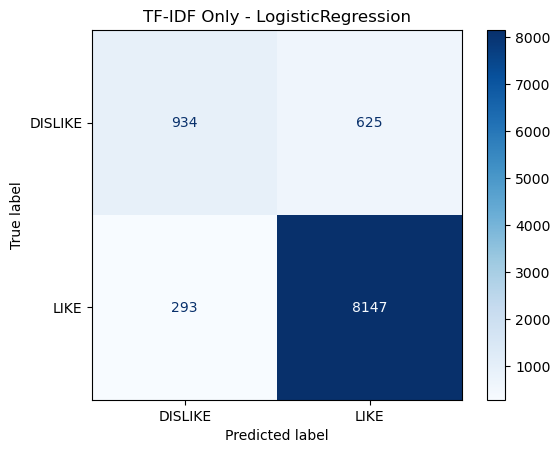


Training RandomForest...
RandomForest - Accuracy: 0.89, F1: 0.94


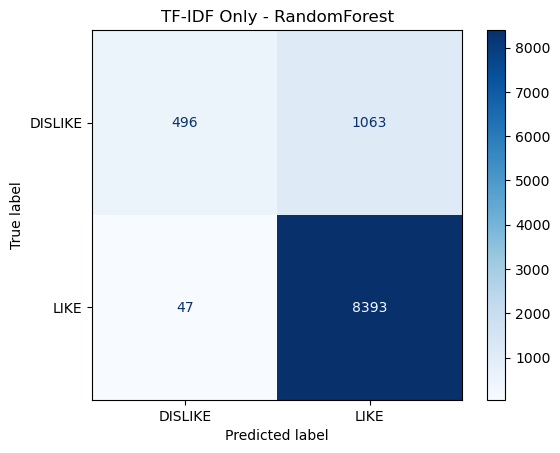


Training GaussianNB...
GaussianNB - Accuracy: 0.78, F1: 0.85


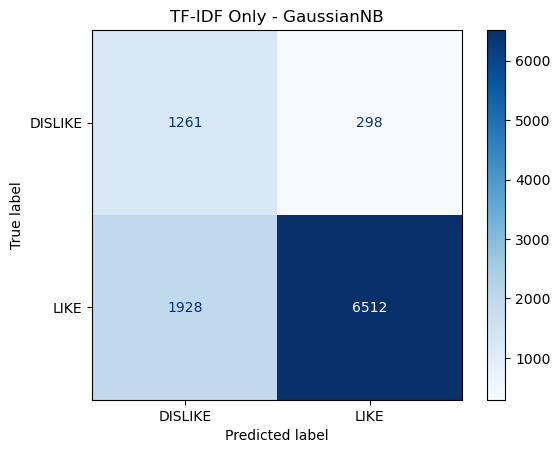


--- Evaluation for: TF-IDF + Engineered ---

Training LogisticRegression...
LogisticRegression - Accuracy: 0.91, F1: 0.95


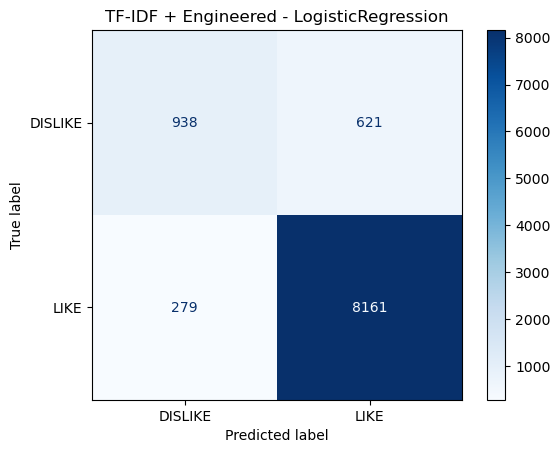


Training RandomForest...
RandomForest - Accuracy: 0.89, F1: 0.94


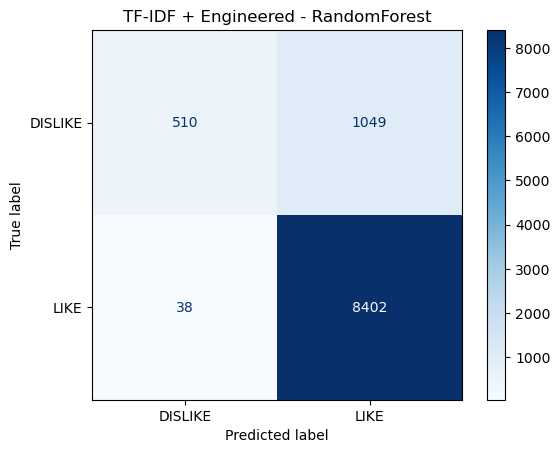


Training GaussianNB...
GaussianNB - Accuracy: 0.78, F1: 0.85


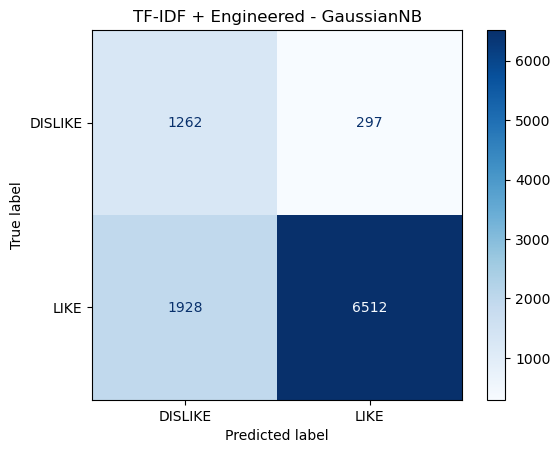


Comparison:
                Model  Accuracy_TFIDF  Precision_TFIDF  Recall_TFIDF  \
0  LogisticRegression            0.91             0.93          0.97   
1        RandomForest            0.89             0.89          0.99   
2          GaussianNB            0.78             0.96          0.77   

   F1_TFIDF                                  Best Params_TFIDF  \
0      0.95  {'model__C': 10, 'model__max_iter': 1000, 'mod...   
1      0.94  {'model__max_depth': None, 'model__n_estimator...   
2      0.85                                                n/a   

   Accuracy_COMBINED  Precision_COMBINED  Recall_COMBINED  F1_COMBINED  \
0               0.91                0.93             0.97         0.95   
1               0.89                0.89             1.00         0.94   
2               0.78                0.96             0.77         0.85   

                                Best Params_COMBINED  
0  {'model__C': 10, 'model__max_iter': 5000, 'mod...  
1  {'model__max_depth': No

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Load pre-split datasets ---
train_df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Filter out neutral reviews (Score = 3) ---
train_df = train_df[train_df['Score'] != 3].copy()
test_df = test_df[test_df['Score'] != 3].copy()

# --- Binarize label ---
train_df['Label'] = train_df['Score'].apply(lambda x: 1 if x > 3 else 0)
test_df['Label'] = test_df['Score'].apply(lambda x: 1 if x > 3 else 0)

# --- Stratified sampling: 40K train, 10K test ---
train_sample = train_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(n=int(40000 * len(x)/len(train_df)), random_state=42))
test_sample = test_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(n=int(10000 * len(x)/len(test_df)), random_state=42))

# --- Define features ---
engineered_features = [
    'TextLengthWords', 
    'NumUppercaseWords', 
    'AvgWordLength', 
    'ContainsNegation', 
    'TextToSummaryRatio', 
    'NumExclamations'
]

# --- Extract raw text and features ---
raw_text_train = train_sample['Text'].astype(str)
raw_text_test = test_sample['Text'].astype(str)
X_eng_train = train_sample[engineered_features]
X_eng_test = test_sample[engineered_features]
y_train = train_sample['Label']
y_test = test_sample['Label']

# --- TF-IDF vectorization ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf_train = tfidf_vectorizer.fit_transform(raw_text_train)
X_tfidf_test = tfidf_vectorizer.transform(raw_text_test)

# --- Scale extended features ---
scaler = StandardScaler()
X_eng_train_scaled = scaler.fit_transform(X_eng_train)
X_eng_test_scaled = scaler.transform(X_eng_test)

# --- Combine TF-IDF with extended features ---
X_comb_train = sp.hstack([X_tfidf_train, X_eng_train_scaled])
X_comb_test = sp.hstack([X_tfidf_test, X_eng_test_scaled])

# --- Define models ---
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GaussianNB': GaussianNB()
}

# --- Hyperparameter grids ---
params = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__solver': ['lbfgs', 'saga'],
        'model__max_iter': [1000, 5000]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [5, 10, None]
    },
    'GaussianNB': {}  # geen hyperparameters
}

# --- Evaluation loop ---
def evaluate_models(X_train, X_test, y_train, y_test, label):
    print(f"\n--- Evaluation for: {label} ---")
    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")
        best_params = "n/a"
        if name == 'GaussianNB':
            X_train_dense = X_train.toarray()
            X_test_dense = X_test.toarray()
            model.fit(X_train_dense, y_train)
            y_pred = model.predict(X_test_dense)
        else:
            pipe = Pipeline([
                ('model', model)
            ])
            grid = GridSearchCV(pipe, params[name], scoring='f1', cv=5, n_jobs=-1)
            grid.fit(X_train, y_train)
            model = grid.best_estimator_
            best_params = grid.best_params_
            y_pred = model.predict(X_test)

        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} - Accuracy: {acc:.2f}, F1: {f1:.2f}")

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DISLIKE', 'LIKE'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{label} - {name}")
        plt.show()

        results.append({
            'Model': name,
            'Accuracy': round(acc, 2),
            'Precision': round(prec, 2),
            'Recall': round(rec, 2),
            'F1': round(f1, 2),
            'Best Params': best_params
        })

    return pd.DataFrame(results)

# --- Run and compare ---
results_tfidf = evaluate_models(X_tfidf_train, X_tfidf_test, y_train, y_test, "TF-IDF Only")
results_combined = evaluate_models(X_comb_train, X_comb_test, y_train, y_test, "TF-IDF + Engineered")

# --- Output ---
comparison = results_tfidf.merge(results_combined, on="Model", suffixes=("_TFIDF", "_COMBINED"))
print("\nComparison:")
print(comparison)
print("\nComparison of Hyperparameters:")
print(comparison[['Model', 'Best Params_TFIDF', 'Best Params_COMBINED']])



In [ ]:
print("\nComparison of Hyperparameters:")
print(comparison[['Model', 'Best Params_TFIDF', 'Best Params_COMBINED']])

for col in ['Best Params_TFIDF', 'Best Params_COMBINED']:
    print(f"\nSolvers from {col}:")
    for i, row in comparison.iterrows():
        if row['Model'] == 'LogisticRegression':
            solver = row[col].get('model__solver', 'not found')
            print(f"{col} → solver: {solver}")



Comparison of Hyperparameters:
                Model                                  Best Params_TFIDF  \
0  LogisticRegression  {'model__C': 10, 'model__max_iter': 1000, 'mod...   
1        RandomForest  {'model__max_depth': None, 'model__n_estimator...   
2          GaussianNB                                                n/a   

                                Best Params_COMBINED  
0  {'model__C': 10, 'model__max_iter': 5000, 'mod...  
1  {'model__max_depth': None, 'model__n_estimator...  
2                                                n/a  

Solvers from Best Params_TFIDF:
Best Params_TFIDF → solver: saga

Solvers from Best Params_COMBINED:
Best Params_COMBINED → solver: saga



Analyzing: LogisticRegression

--- Feature Importance: LogisticRegression ---
           Feature  Importance
374          great   12.739482
92            best   10.400014
234      delicious    9.663672
640        perfect    9.283326
293      excellent    8.197413
859       terrible    8.103694
916  unfortunately    7.414976
414       horrible    7.105378
405         highly    7.069835
245   disappointed    7.008963
367           good    6.979081
716         return    6.947292
66           awful    6.881058
572            not    6.746426
978      wonderful    6.584151


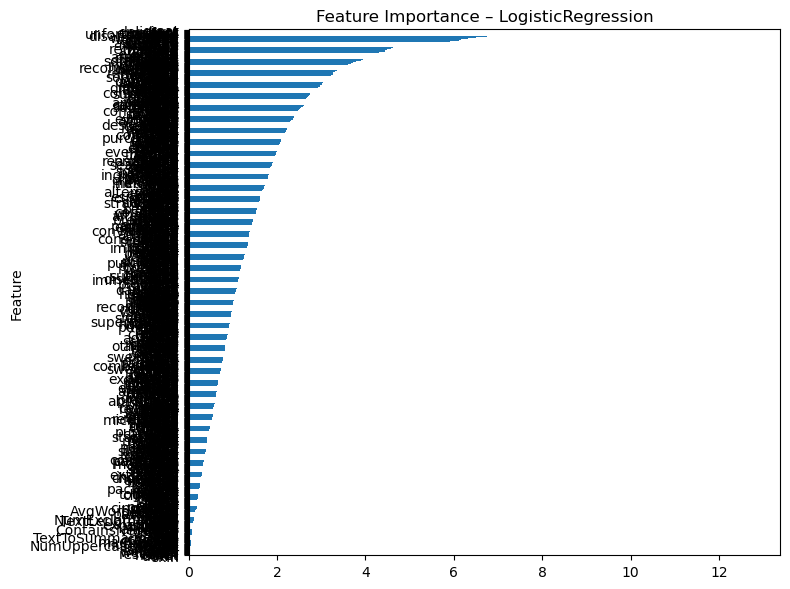


Analyzing: RandomForest

--- Feature Importance: RandomForest ---
                 Feature  Importance
572                  not    0.021351
245         disappointed    0.013237
374                great    0.013013
943                  was    0.011212
865                  the    0.009568
945                waste    0.009098
1002       AvgWordLength    0.008692
1003    ContainsNegation    0.008684
1000     TextLengthWords    0.008084
1004  TextToSummaryRatio    0.007930
43                   and    0.007921
859             terrible    0.007524
716               return    0.007030
69                   bad    0.006886
585                   of    0.006878


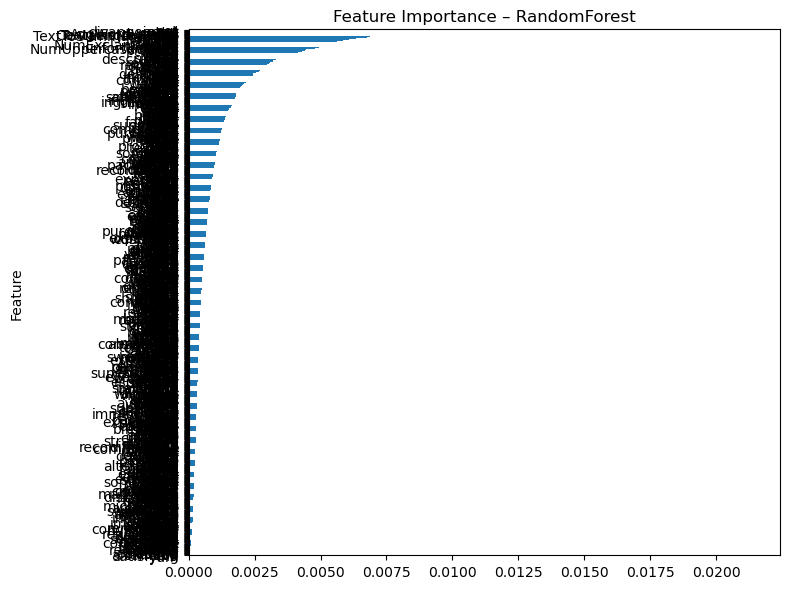


Analyzing: GaussianNB

--- Feature Importance: GaussianNB ---
                 Feature  Importance
1003    ContainsNegation    0.460995
1001   NumUppercaseWords    0.174200
1000     TextLengthWords    0.160408
1005     NumExclamations    0.150808
1004  TextToSummaryRatio    0.103299
1002       AvgWordLength    0.069761
572                  not    0.031431
943                  was    0.027097
374                great    0.024770
865                  the    0.022309
501                 love    0.016951
92                  best    0.013204
245         disappointed    0.012966
957                 were    0.012086
985                would    0.011742


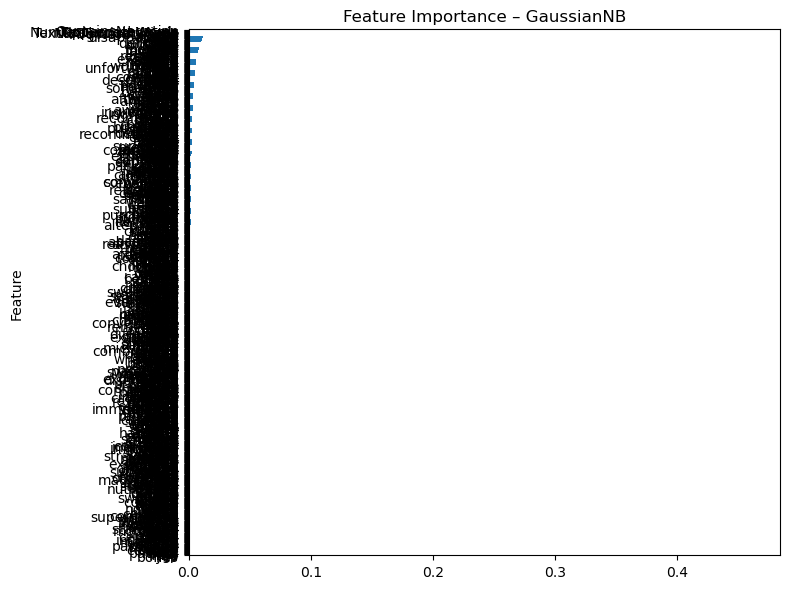

In [ ]:
# --- Feature importance analysis for TF-IDF + extended ---
def feature_importance_analysis(model, feature_names, model_name):
    print(f"\n--- Feature Importance: {model_name} ---")
    
    if model_name == "RandomForest":
        importances = model.feature_importances_
    elif model_name == "LogisticRegression":
        importances = np.abs(model.coef_[0])
    elif model_name == "GaussianNB":
        importances = np.abs(model.theta_[1] - model.theta_[0])
    else:
        raise ValueError("Unsupported model for feature importance.")
    
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print(importance_df.head(15))  # top 15
    importance_df.plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6), legend=False)
    plt.title(f"Feature Importance – {model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# --- Reconstruct feature names ---
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = list(tfidf_feature_names) + engineered_features

# --- Fit and analyze each model ---
for name, base_model in models.items():
    print(f"\nAnalyzing: {name}")
    
    if name == 'GaussianNB':
        fitted_model = base_model.fit(X_comb_train.toarray(), y_train)
    else:
        pipe = Pipeline([('model', base_model)])
        grid = GridSearchCV(pipe, params[name], scoring='f1', cv=5, n_jobs=-1)
        grid.fit(X_comb_train, y_train)
        fitted_model = grid.best_estimator_.named_steps['model']  
    
    feature_importance_analysis(fitted_model, all_feature_names, name)

